In [11]:
from simpletransformers.seq2seq import Seq2SeqModel
from sklearn.model_selection import train_test_split
import seaborn as sns

import pandas as pd
import os
import evaluate
import numpy as np

In [33]:
data_path = os.path.join('../data/interim/preprocessed.tsv')
models_path = os.path.join('../models')

In [34]:
df = pd.read_csv(data_path, sep='\t')

df = df.rename(columns={"reference": "input_text", "translation": "target_text"})
train, test = train_test_split(df, test_size=0.2)
test = pd.DataFrame(test, columns = ['input_text','target_text', 'ref_tox', 'trn_tox']).sample(1000)
input = test['input_text']
target = test['target_text']

In [12]:
model = Seq2SeqModel(
    encoder_decoder_type="bart", 
    encoder_decoder_name=models_path,
    
)

predict = model.predict(input.tolist())
predict[:10]

Generating outputs:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\Anthony\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
C:\Users\Anthony\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `2.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`.
  warnings.warn(


["That's the only truth you've ever said in your life",
 'no hipsters and no virgins.',
 'You would take my daughter.',
 'how does he know about such things?',
 'Yeah, she is a psycho, but it proves the psychic is not, right?',
 'the "poison" is three hundred bucks, and you can\'t get it in America, so don\'t drink it!',
 "Andy's not dirty, he's my man.",
 'listen to the Blackguard.',
 "“You're wasting a car,” he said.",
 'He also ordered me to kill Ladislaus Girescho, Batu said.']

In [13]:
df = test.loc[input.index]
df["predict"] = predict
df.to_csv('../data/interim/predict.tsv', sep="\t")

In [52]:
df = pd.read_csv('../data/interim/predict.tsv', sep='\t')

In [59]:
toxicity = evaluate.load("toxicity", module_type="measurement")
results = toxicity.compute(predictions=df['predict'].apply(lambda x: x.lower()).to_list())

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


In [60]:
df['predict_tox'] = pd.Series(results['toxicity'])

In [61]:
df.head()

,Unnamed: 0,input_text,target_text,ref_tox,trn_tox,predict,predict_tox
0,368081,"where the hell did they come from? ""","But where on earth did they come from?""",0.978349,0.022792,"Where on earth did they come from?""",0.467599
1,374168,Don't that look like Boom Boom's bike over the...,doesn't that motorcycle look like Boom Boom?,0.999373,0.000042,does it not look like Boom Boom's bike over th...,0.002833
2,63730,"I managed to talk them into it, and then you f...",I managed to talk them down and you had to poo...,0.998523,0.046425,"I talked them into it, and then you screw it up?",0.008327
3,199713,"Happy birthday, asshole.","happy birthday, dude.",0.999559,0.000070,"happy birthday, man.",0.000415
4,131478,I fucked it up when I was little.,I used to love that place when I was a kid.,0.970808,0.000052,I screwed up when I was a kid.,0.027289


In [66]:
df_ref = pd.DataFrame({"tox": df["ref_tox"],
                       "label": pd.Series(["ref"] * df["ref_tox"].shape[0])})
df_trn = pd.DataFrame({"tox": df["trn_tox"],
                       "label": pd.Series(["trn"] * df["trn_tox"].shape[0])})
df_predict = pd.DataFrame({"tox": df["predict_tox"],
                       "label": pd.Series(["predict"] * df["predict_tox"].shape[0])})
df_scores = pd.concat([df_ref, df_trn, df_predict]).reset_index(drop=True)

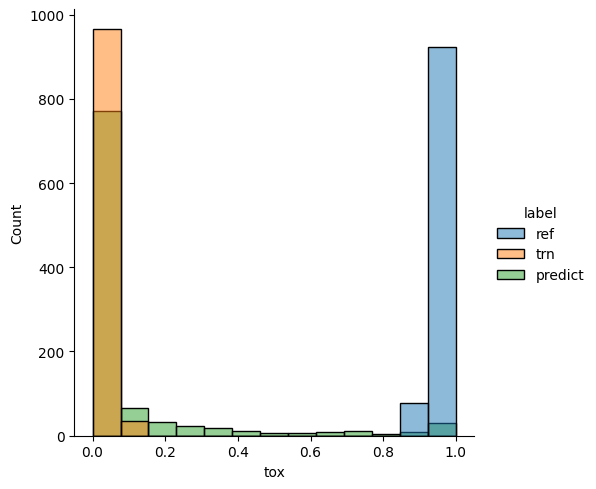

In [70]:
sns.displot(data=df_scores, x="tox", hue="label")

In [72]:
toxicity = evaluate.load("toxicity", module_type="measurement")
ref_tox = toxicity.compute(predictions=df['input_text'].apply(lambda x: x.lower()).to_list())

toxicity = evaluate.load("toxicity", module_type="measurement")
trn_tox = toxicity.compute(predictions=df['target_text'].apply(lambda x: x.lower()).to_list())

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint
Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


In [76]:
ref_tox, trn_tox = ref_tox["toxicity"], trn_tox["toxicity"]

In [77]:
df_ref2 = pd.DataFrame({"tox": pd.Series(ref_tox),
                       "label": pd.Series(["ref"] * df["ref_tox"].shape[0])})
df_trn2 = pd.DataFrame({"tox": pd.Series(trn_tox),
                       "label": pd.Series(["trn"] * df["trn_tox"].shape[0])})
df_scores2 = pd.concat([df_ref2, df_trn2, df_predict]).reset_index(drop=True)

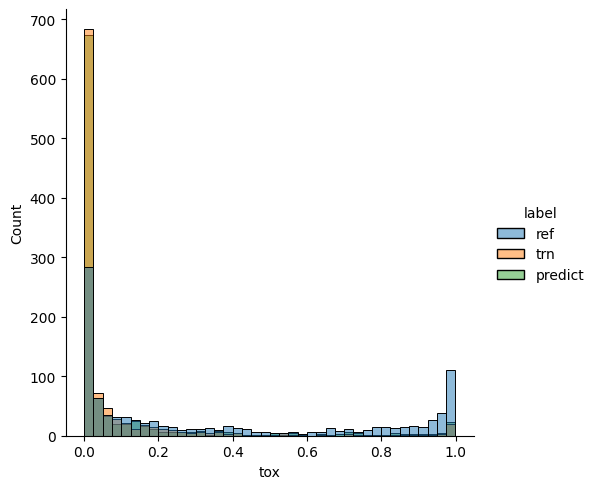

In [79]:
sns.displot(data=df_scores2, x="tox", hue="label")

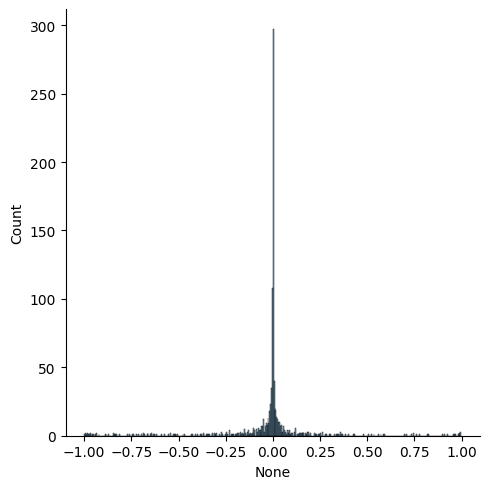

In [81]:
sns.displot(x=pd.Series(trn_tox)-df['predict_tox'], alpha=0.5, linewidth=0.3)